# Notebook Overview

The goal of this experiment is to demonstrate how features search can lead to generalization in complex, non-linear problems. The intention behind this particular experiment setup is to clearly demonstrate the importance of network architecture in generalization (though this is not the only way generalization can happen).

1. Create a deep, sparse target network. Create an equally deep, wider, and densely connected learning network. Show that the target function can be learned even in the streaming setting. This will involve testing different optimizers, hyperparameters, and changing the size of the target network so that the target function is learnable in a reasonable number of steps. Then do another run to see what happens if the input is changing.
2. Change the learning network to be shallower than the target network, but still retain significantly more weights. Train the learning network on the target network with inputs sampled from a subset of the input distribution. Change the subset of the input distribution being sampled from every fixed number of steps. Show that the learning network can get to nearly perfect performance, but the network needs to relearn whenever the input distribution is changed. This is the first baseline. This step will require tuning how the input distribution subsets are chosen and how the steps between distribution shifts are chosen to demonstrate this possibility.
3. Go back to the setup in step 1, but now limit the learner's capacity, and initialize it with a sparse set of weights. The capacity needs to be greater than that of the target network, but low enough that it is extremely unlikely that its initial setup can perfectly solve the problem. This is the second baseline.
4. Adding onto step 3, train the learner with continual backprop in every layer. The learner should be capable of finding the exact solution, and the loss should not increase even when the input distribution shifts.
5. I could optionally try another approach where I add just one unit to each layer at a time then prune it, adding more units as I get the capacity.

1. Deep, sparse target network. Equally deep, wider, dense learning network.
2. Same as step 1 with changing input distribution.

Steps 1 and 2 should both be possible to learn perfectly, maybe? Step 1 for sure, but step 2 uncertain.
If step 2 isn't possible when overparameterized, why would it be possible with less parameters?
I'm not sure it would be, so let's start there. 

In [2]:
from concurrent.futures import as_completed, ThreadPoolExecutor
from functools import partial
import hashlib
import inspect
import itertools
import os
import pickle
import random
from typing import Any, Callable, Dict, List, Optional

import equinox as eqx
import hydra
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import DictConfig, OmegaConf
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from phd.feature_search.analysis.plotting import plot_learning_curves, plot_param_sensitivity
from phd.feature_search.scripts.jax_full_feature_search import run_experiment
from phd.feature_search.jax_core.experiment_helpers import prepare_components, rng_from_string
from phd.feature_search.jax_core.utils import tree_replace

%matplotlib inline

if not hydra.core.global_hydra.GlobalHydra().is_initialized():
    hydra.initialize(config_path='../conf')

/home/edan/local_projects/phd_research/phd/feature_search/scripts/jax_full_feature_search.py:430: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')
/tmp/ipykernel_6009/3623990411.py:30: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


In [3]:
DATA_DIR = 'data/generalization_first_experiment'
os.makedirs(DATA_DIR, exist_ok=True)


def get_experiment_data(hash: str):
    if not os.path.exists(os.path.join(DATA_DIR, f'{hash}.pkl')):
        return None
    
    with open(os.path.join(DATA_DIR, f'{hash}.pkl'), 'rb') as f:
        data = pickle.load(f)
    return data


def save_experiment_data(hash: str, data: Any):
    with open(os.path.join(DATA_DIR, f'{hash}.pkl'), 'wb') as f:
        pickle.dump(data, f)


def cache_fn(fn: Callable, ignore: List[str] = [], check_fn_body: bool = False):
    def cached_fn(*args, **kwargs):
        signature = inspect.signature(fn)
        bound_args = signature.bind(*args, **kwargs)
        bound_args.apply_defaults()
        args_dict = bound_args.arguments
        for ignore_arg in ignore:
            args_dict.pop(ignore_arg)
        
        for key, value in args_dict.items():
            if isinstance(value, DictConfig):
                args_dict[key] = OmegaConf.to_container(value)
        
        hash_data = args_dict
        if check_fn_body:
            hash_data = (hash_data, fn.__code__.co_code)
        
        argument_bytes = pickle.dumps(hash_data)
        hash = hashlib.sha256(argument_bytes).hexdigest()
        experiment_data = get_experiment_data(hash)
        if experiment_data is not None:
            return experiment_data
        
        result = fn(*args, **kwargs)
        save_experiment_data(hash, result)
        return result
    
    return cached_fn

In [4]:
def prepare_experiment(cfg):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker = \
        prepare_components(cfg)
    
    if cfg.seed is not None:
        rng = jax.random.key(cfg.seed)
    else:
        rng = jax.random.key(random.randint(0, 2**31))

    task_init_key = rng_from_string(rng, 'task_init_key')
    task.weights[-1] = jax.random.uniform(
        task_init_key,
        task.weights[-1].shape,
        dtype = task.weights[-1].dtype,
        minval = -jnp.sqrt(6 / task.weights[-1].shape[0]),
        maxval = jnp.sqrt(6 / task.weights[-1].shape[0]),
    )
    
    # Set the target network output layer weights as to standardize
    # the output over the input support
    sample_inputs = jax.random.uniform(
        key = jax.random.PRNGKey(0),
        shape = (10_000, task.n_features),
        dtype = jnp.float32,
        minval = task.input_bounds[0],
        maxval = task.input_bounds[1],
    )
    sample_outputs = task._forward(sample_inputs)

    mean_output = jnp.mean(sample_outputs)
    std_output = jnp.std(sample_outputs)

    task.weights[-1] = task.weights[-1] / std_output
    task = tree_replace(task, bias = -mean_output / std_output)
    
    model = eqx.tree_at(
        lambda m: m.layers[-1].weight, model,
        jnp.zeros_like(model.layers[-1].weight),
    )
    return task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng


@partial(cache_fn, ignore=['show_progress'])
def prepare_and_run_experiment(cfg, show_progress: bool = True, callback = None):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng = \
        prepare_experiment(cfg)
    
    jax.config.update('jax_compilation_cache_dir', cfg.jax_jit_cache_dir)
    jax.config.update('jax_persistent_cache_min_entry_size_bytes', -1)
    jax.config.update('jax_persistent_cache_min_compile_time_secs', 0.1)
    jax.config.update('jax_persistent_cache_enable_xla_caches', 'xla_gpu_per_fusion_autotune_cache_dir')
    
    kwargs = dict(
        cfg = cfg,
        task = task,
        model = model,
        criterion = criterion,
        optimizer = optimizer,
        repr_optimizer = repr_optimizer,
        cbp_tracker = cbp_tracker,
        distractor_tracker = None,
        rng = rng,
        show_progress = show_progress,
    )
    
    if callback is not None:
        kwargs = callback(kwargs)
    
    train_state, task, metrics = run_experiment(**kwargs)
    
    return {
        'config': cfg,
        'metrics': metrics,
    }

In [20]:
def set_cfg_val(cfg, param_path, val):
    path = param_path.split('.')
    sub_cfg = cfg
    for p in path[:-1]:
        sub_cfg = sub_cfg.get(p)
    sub_cfg[path[-1]] = val
    return cfg


def get_cfg_val_from_path(cfg, param_path):
    path = param_path.split('.')
    sub_cfg = cfg
    for p in path[:-1]:
        sub_cfg = sub_cfg.get(p)
    return sub_cfg[path[-1]]


def create_sweep_configs(base_cfg: DictConfig, sweep_params: Dict, n_seeds: int):
    """Creates a cartesian product of all config changes and seeds."""
    sweep_configs = []
    base_seed = base_cfg.seed if base_cfg.seed is not None else random.randint(0, 2**30)
    
    # First create all possible combinations of parameter values
    param_names = list(sweep_params.keys())
    param_values = [sweep_params[name] for name in param_names]
    
    # For each combination of parameters
    for values in itertools.product(*param_values):
        # For each seed
        for seed in range(base_seed, base_seed + n_seeds):
            cfg = base_cfg.copy()
            cfg.seed = seed
            
            # Apply all parameter changes
            for param_path, val in zip(param_names, values):
                cfg = set_cfg_val(cfg, param_path, val)
                
            sweep_configs.append(cfg)
            
    return sweep_configs


def run_sweep(base_cfg: DictConfig, sweep_params: Dict, n_seeds: int, n_threads: int, callback: Optional[Callable] = None):
    sweep_configs = create_sweep_configs(base_cfg, sweep_params, n_seeds)
    total = len(sweep_configs)
    results = []
    # Use threading instead of multiprocessing to avoid JAX fork issues
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = []
        for cfg in sweep_configs:
            futures.append(executor.submit(prepare_and_run_experiment, cfg, False, callback))
        
        for future in tqdm(as_completed(futures), total=total, desc="Running experiments"):
            results.append(future.result())
            
    df = sweep_results_to_df(results, sweep_params)
    return df


def sweep_results_to_df(results, sweep_params):
    metrics = results[0]['metrics']
    columns = ['run_id', 'seed'] + list(sweep_params.keys()) + list(metrics.keys())

    rows = []
    for run_id, result in enumerate(results):
        config = result['config']
        metrics = result['metrics']
        metric_values = np.array(jnp.stack(metrics.values()).T) # (n_rows, n_metrics)
        n_rows = metric_values.shape[0]
        for i in range(n_rows):
            row = [run_id, config.seed]
            for param_name in sweep_params.keys():
                row.append(get_cfg_val_from_path(config, param_name))
            row.extend(metric_values[i].tolist())
            rows.append(row)

    return pd.DataFrame(rows, columns=columns)


def default_param_sensitivity_plot(
    df: pd.DataFrame,
    x_col: str,
    x_label: str,
    title: str,
    hue_col: str,
    legend_title: str,
    pow_2_x_axis: bool = False,
    show_ci: bool = True,
):
    plot_param_sensitivity(
        run_df = df,
        config_df = None,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = 'loss',
        metric_col = 'loss',
        metric_type = 'final_avg', # {'cumulative', 'final_avg', 'last'}
        step_col = 'step',
        id_col = 'run_id',
        hue_col = hue_col,
        legend_title = legend_title,
        show_ci = show_ci,
        pow_2_x_axis = pow_2_x_axis,
    )


def default_learning_curve_plot(
    df: pd.DataFrame,
    hue_col: str,
    legend_title: str,
    subplot_col: str,
    subplot_col_label: str,
    pow_2_legend: bool = False,
    same_y_axis: bool = True,
):
    plot_learning_curves(
        run_df = df,
        subplot_col = subplot_col,
        n_bins = 200,
        figsize = (12, 10),
        max_cols = 2,
        subplot_col_label = subplot_col_label,
        same_y_axis = same_y_axis,
        x_col = 'step',
        y_col = 'loss',
        y_label = 'loss',
        hue_col = hue_col,
        legend_title = legend_title,
        pow_2_legend = pow_2_legend,
    )

## Step 1: Overparameterization

In [21]:
experiment_base_cfg = DictConfig(dict(
    seed = 20250927,
    task = {
        'name': 'input_changing_geoff',
        'n_features': 64,
        'n_real_features': '${task.n_features}',
        'flip_rate': 0.0,
        'n_layers': 3,
        'n_stationary_layers': '${task.n_layers}',
        'hidden_dim': 64,
        'activation': 'ltu',
        'sparsity': 0.99,
        'weight_init': 'binary',
        'noise_std': 0.0,
        'input_subspace_range': 2.0,
        'input_change_freq': None,
    },
    train = {
        'batch_size': 1,
        'total_steps': 1_000_000,
        'standardize_cumulants': False,
        'log_freq': 1000,
    },
    feature_recycling = {
        'use_cbp_utility': True,
        'use_signed_utility': False,
        'recycle_rate': 0.0,
        'utility_decay': 0.99,
        'feature_protection_steps': 100,
        'prune_frequency': 4,
    },
    model = {
        'output_dim': 1,
        'n_layers': 3,
        'hidden_dim': 512,
        'weight_init_method': 'lecun_uniform', # Input layer only
        'activation': 'ltu',
        'n_frozen_layers': 0,
        'use_bias': True,
    },
    optimizer = {
        'name': 'sgd',
        'learning_rate': 0.001,
    },
))

# Load hydra config
default_cfg = hydra.compose(config_name='input_changing_geoff')
step_1_cfg = OmegaConf.merge(default_cfg, experiment_base_cfg)

/home/edan/miniconda3/envs/jax/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'input_changing_geoff': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### Optimizer sweep

Running experiments: 100%|██████████| 63/63 [00:00<00:00, 413.60it/s]


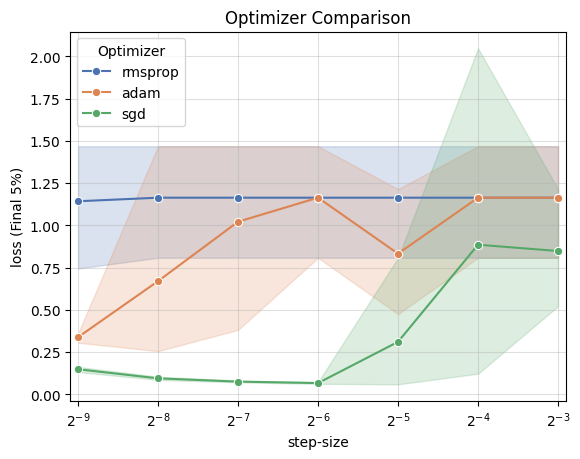

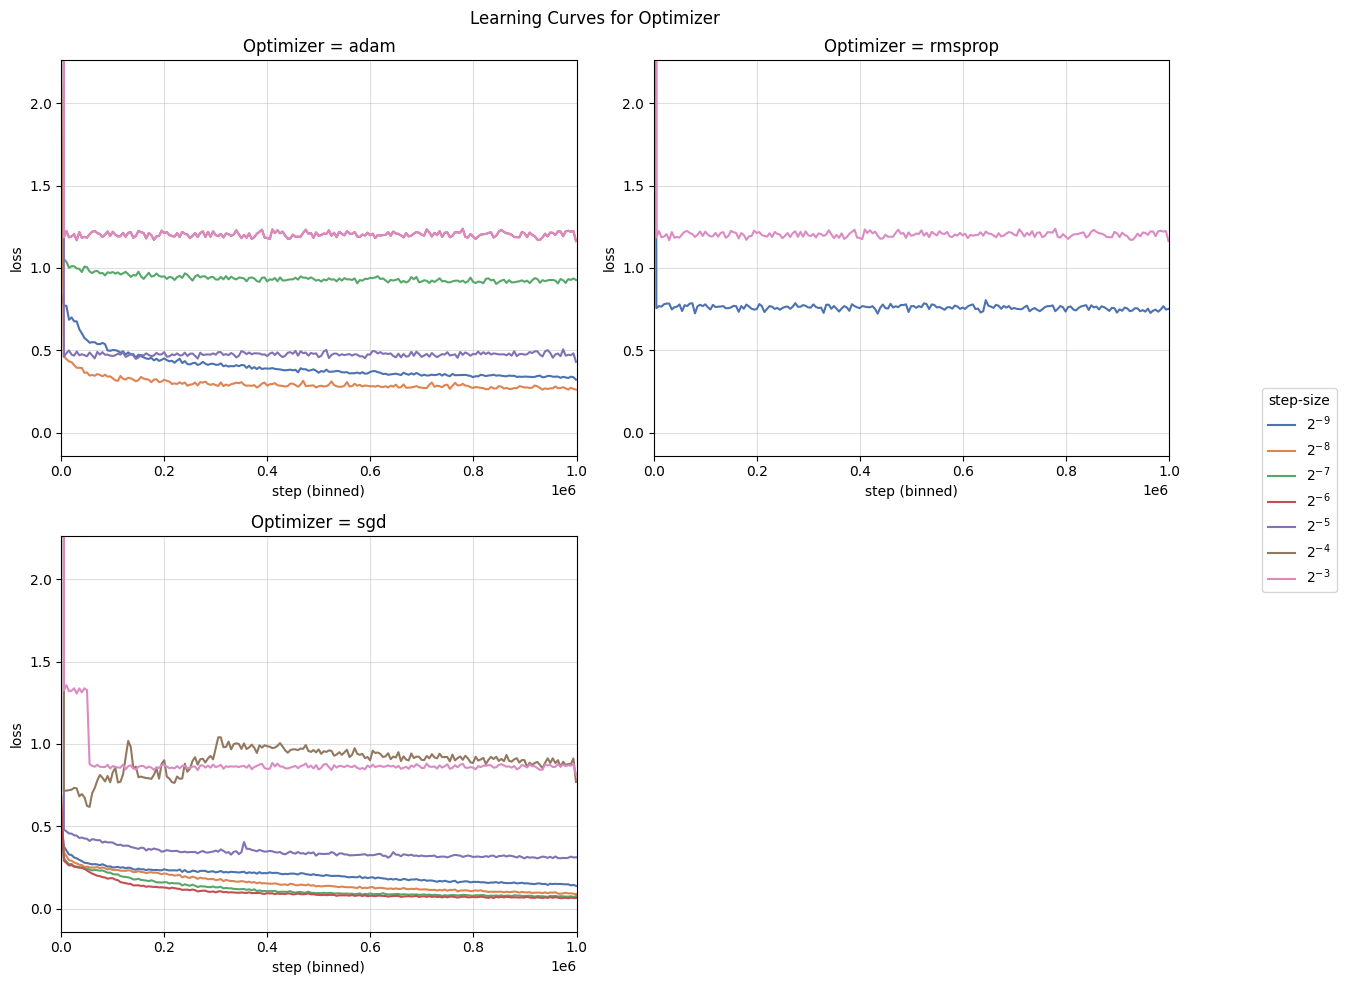

In [22]:
step_sizes = jnp.array([2**i for i in range(-3, -10, -1)]).tolist()
# step_sizes = jnp.array([2**i for i in range(-6, -8, -1)]).tolist()

sweep_params = {
    'optimizer.learning_rate': step_sizes,
    'optimizer.name': ['rmsprop', 'adam', 'sgd'],
}

# Make a callback that centers the input distributions
def center_input_distributions(experiment_kwargs):
    task = experiment_kwargs['task']
    task = tree_replace(
        task,
        input_subspace_centers = jnp.zeros_like(task.input_subspace_centers),
    )
    return experiment_kwargs

### Run Sweep ###

df = run_sweep(
    step_1_cfg,
    sweep_params = sweep_params,
    n_seeds = 3,
    n_threads = 4,
    callback = center_input_distributions,
)

### Plot ###

default_param_sensitivity_plot(
    df,
    x_col = 'optimizer.learning_rate',
    x_label = 'step-size',
    title = 'Optimizer Comparison',
    hue_col = 'optimizer.name',
    legend_title = 'Optimizer',
    pow_2_x_axis = True,
)
plt.show()

default_learning_curve_plot(
    df,
    hue_col = 'optimizer.learning_rate',
    legend_title = 'step-size',
    subplot_col = 'optimizer.name',
    subplot_col_label = 'Optimizer',
    pow_2_legend = True,
    same_y_axis = True,
)
plt.show()

Running experiments: 100%|██████████| 72/72 [00:00<00:00, 421.25it/s]


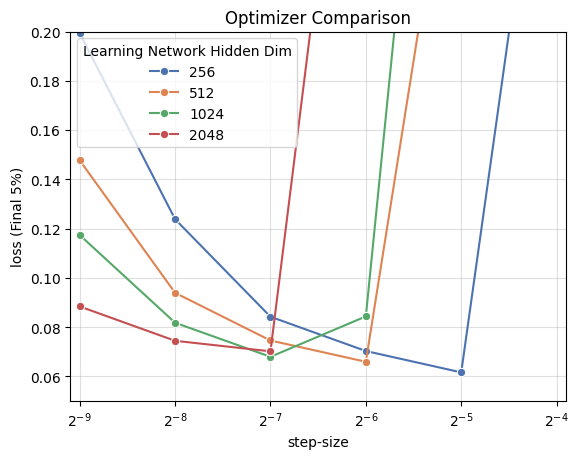

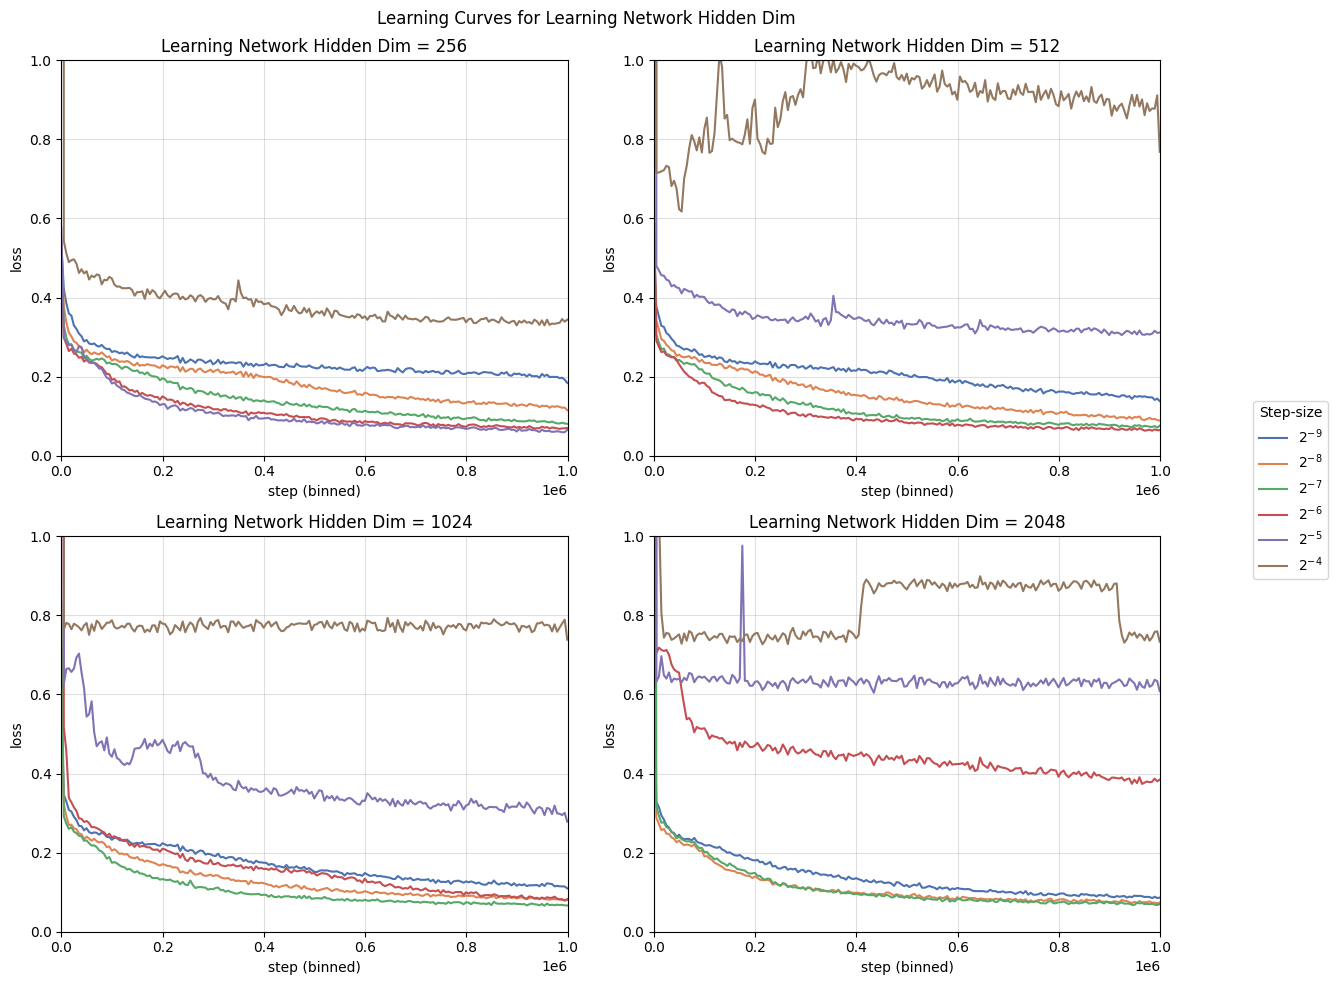

In [26]:
step_sizes = jnp.array([2**i for i in range(-4, -10, -1)]).tolist()

sweep_params = {
    'optimizer.learning_rate': step_sizes,
    'optimizer.name': ['sgd'],
    'model.hidden_dim': [256, 512, 1024, 2048],
}

# Make a callback that centers the input distributions
def center_input_distributions(experiment_kwargs):
    task = experiment_kwargs['task']
    task = tree_replace(
        task,
        input_subspace_centers = jnp.zeros_like(task.input_subspace_centers),
    )
    return experiment_kwargs

### Run Sweep ###

df = run_sweep(
    step_1_cfg,
    sweep_params = sweep_params,
    n_seeds = 3,
    n_threads = 4,
    callback = center_input_distributions,
)

### Plot ###

default_param_sensitivity_plot(
    df,
    x_col = 'optimizer.learning_rate',
    x_label = 'step-size',
    title = 'Optimizer Comparison',
    hue_col = 'model.hidden_dim',
    legend_title = 'Learning Network Hidden Dim',
    pow_2_x_axis = True,
    show_ci = False,
)
plt.ylim(0.05, 0.2)
plt.show()

default_learning_curve_plot(
    df,
    hue_col = 'optimizer.learning_rate',
    legend_title = 'Step-size',
    subplot_col = 'model.hidden_dim',
    subplot_col_label = 'Learning Network Hidden Dim',
    pow_2_legend = True,
    same_y_axis = True,
)
for ax in plt.gcf().axes:
    ax.set_ylim(0.0, 1.0)
plt.show()

In [ ]:
step_sizes = jnp.array([2**i for i in range(-3, -10, -1)]).tolist()
# step_sizes = jnp.array([2**i for i in range(-6, -8, -1)]).tolist()

sweep_params = {
    'optimizer.learning_rate': step_sizes,
    'optimizer.name': ['rmsprop', 'adam', 'sgd'],
}

# Make a callback that centers the input distributions
def center_input_distributions(experiment_kwargs):
    task = experiment_kwargs['task']
    task = tree_replace(
        task,
        input_subspace_centers = jnp.zeros_like(task.input_subspace_centers),
    )
    return experiment_kwargs

### Run Sweep ###

df = run_sweep(
    step_1_cfg,
    sweep_params = sweep_params,
    n_seeds = 3,
    n_threads = 4,
    callback = center_input_distributions,
)

### Plot ###

default_param_sensitivity_plot(
    df,
    x_col = 'optimizer.learning_rate',
    x_label = 'step-size',
    title = 'Optimizer Comparison',
    hue_col = 'optimizer.name',
    legend_title = 'Optimizer',
    pow_2_x_axis = True,
)
plt.show()

default_learning_curve_plot(
    df,
    hue_col = 'optimizer.learning_rate',
    legend_title = 'step-size',
    subplot_col = 'optimizer.name',
    subplot_col_label = 'Optimizer',
    pow_2_legend = True,
    same_y_axis = True,
)
plt.show()

Running experiments: 100%|██████████| 2/2 [00:00<00:00, 658.29it/s]


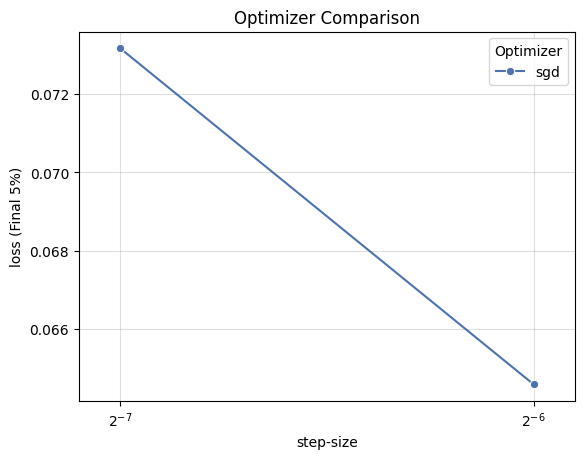

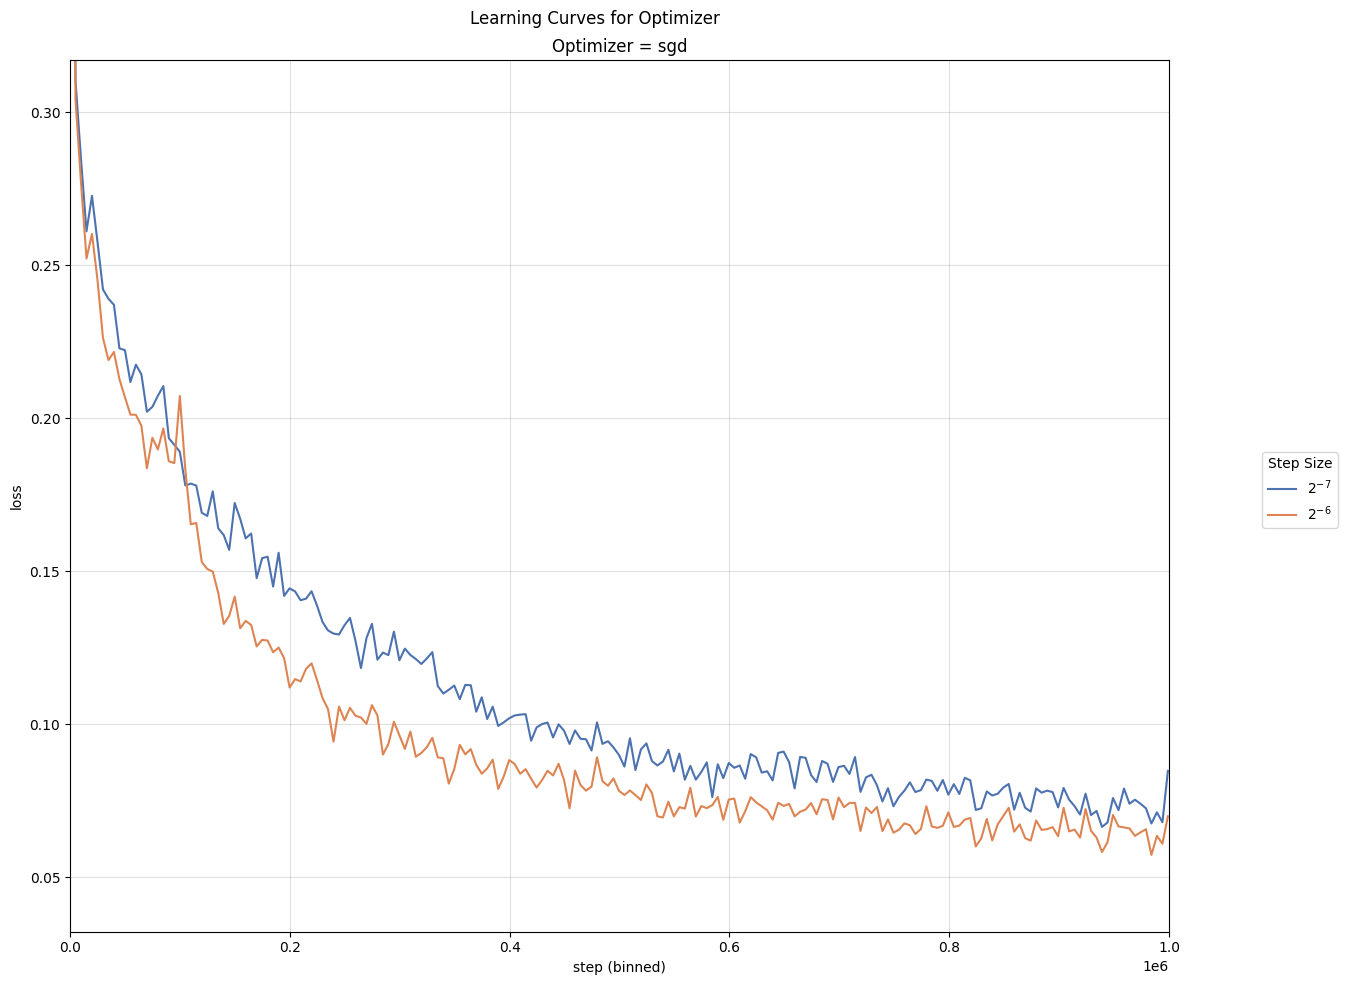

In [ ]:
step_sizes = jnp.array([2**i for i in range(-3, -10, -1)]).tolist()
# step_sizes = jnp.array([2**i for i in range(-6, -8, -1)]).tolist()

sweep_params = {
    'optimizer.learning_rate': step_sizes,
    'optimizer.name': ['rmsprop', 'adam', 'sgd'],
}

# Make a callback that centers the input distributions
def center_input_distributions(experiment_kwargs):
    task = experiment_kwargs['task']
    task = tree_replace(
        task,
        input_subspace_centers = jnp.zeros_like(task.input_subspace_centers),
    )
    return experiment_kwargs

### Run Sweep ###

df = run_sweep(
    step_1_cfg,
    sweep_params = sweep_params,
    n_seeds = 1,
    n_threads = 4,
    callback = center_input_distributions,
)

### Plot ###

default_param_sensitivity_plot(df)
plt.show()

default_learning_curve_plot(df)
plt.show()

If in the above runs SGD is the only optimizer that does well, then I should do more runs with SGD for a longer time.

The only other thing I might want to do is implement the three other optimizers to try:
- SGD + final Autostep layer
- Autostep applied without second order term
- Autostep applied to each layer as a linear layer

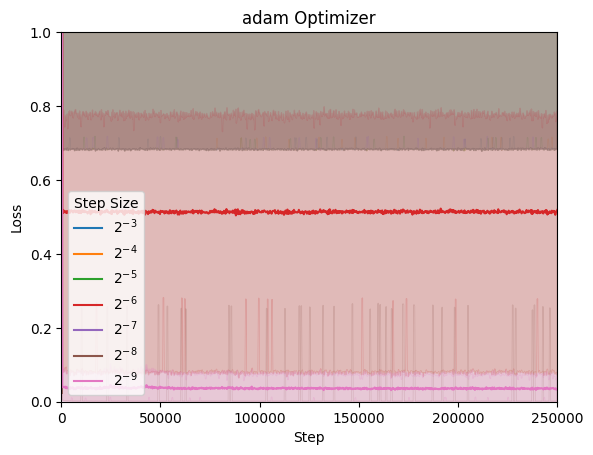

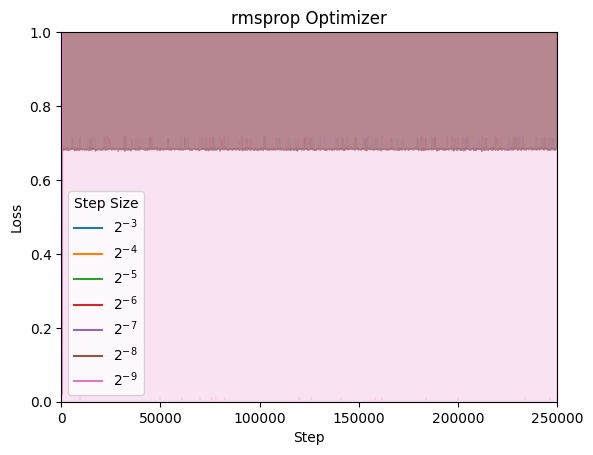

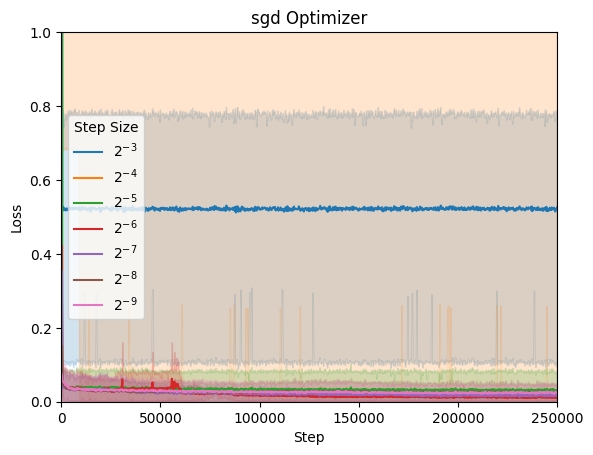

In [8]:
for optimizer_name, optim_df in df.groupby('optimizer.name'):
    # Convert learning rates to 2^n format
    optim_df['optimizer.learning_rate'] = optim_df['optimizer.learning_rate'].apply(
        lambda x: f'$2^{{{int(np.log2(float(x)))}}}$' if float(x) != 0 else '0')
    sns.lineplot(data=optim_df, x='samples', y='loss', hue='optimizer.learning_rate')
    plt.title(f'{optimizer_name} Optimizer')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.xlim(0, df['samples'].max())
    plt.ylim(0, 1)
    plt.legend(title='Step Size')
    plt.show()

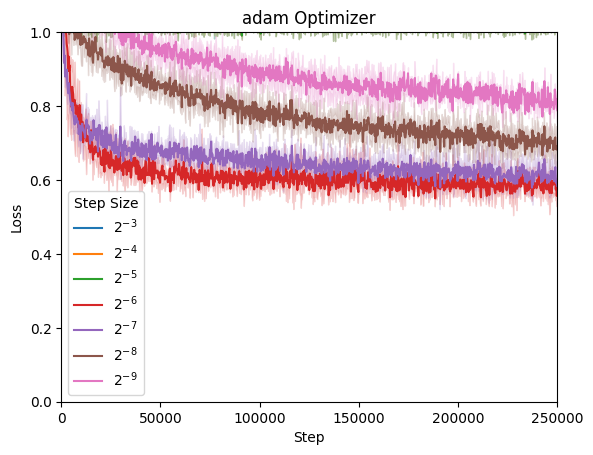

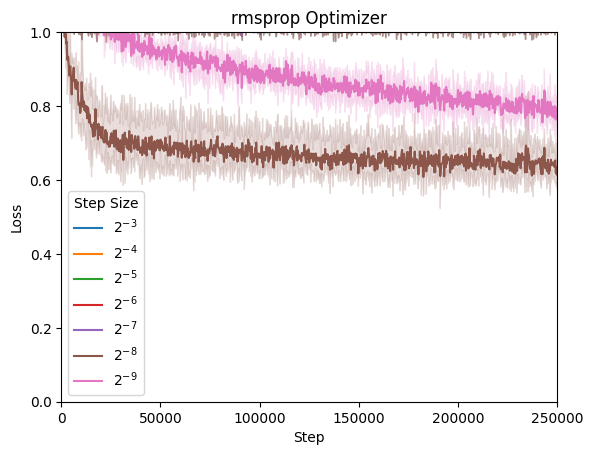

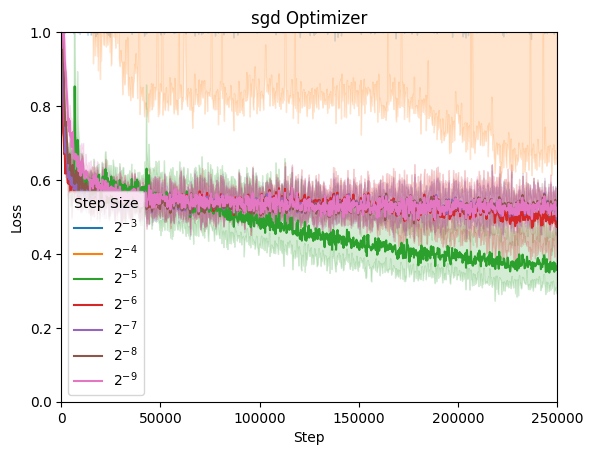

In [7]:
for optimizer_name, optim_df in df.groupby('optimizer.name'):
    # Convert learning rates to 2^n format
    optim_df['optimizer.learning_rate'] = optim_df['optimizer.learning_rate'].apply(
        lambda x: f'$2^{{{int(np.log2(float(x)))}}}$' if float(x) != 0 else '0')
    sns.lineplot(data=optim_df, x='samples', y='loss', hue='optimizer.learning_rate')
    plt.title(f'{optimizer_name} Optimizer')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.xlim(0, df['samples'].max())
    plt.ylim(0, 1)
    plt.legend(title='Step Size')
    plt.show()

## Step 2: Overparameterization + changing input distribution







In [ ]:
step_2_overrides = DictConfig(dict(
    seed = 20250927,
    task = {
        'max_input_center_change': 2.0,
        'input_change_freq': 10_000,
    },
    train = {
        'total_steps': 1_000_000,
    },
    optimizer = {
        'name': 'sgd',
        'learning_rate': 0.001,
    },
))

# Load hydra config
step_2_cfg = OmegaConf.merge(step_1_cfg, step_2_overrides)

## Step 2: Changing input distribution

In [ ]:
experiment_base_cfg = DictConfig(dict(
    seed = 20250927,
    task = {
        'name': 'input_changing_geoff',
        'n_features': 10,
        'n_real_features': '${task.n_features}',
        'flip_rate': 0.0,
        'n_layers': 3,
        'n_stationary_layers': '${task.n_layers}',
        'hidden_dim': 64,
        'activation': 'ltu',
        'sparsity': 0.95,
        'weight_init': 'binary',
        'noise_std': 0.0,
        'input_change_freq': None,
    },
    train = {
        'batch_size': 1,
        'total_steps': 1_000_000,
        'standardize_cumulants': False,
        'log_freq': 1000,
    },
    feature_recycling = {
        'use_cbp_utility': True,
        'use_signed_utility': False,
        'recycle_rate': 0.0,
        'utility_decay': 0.99,
        'feature_protection_steps': 100,
        'prune_frequency': 4,
    },
    model = {
        'output_dim': 1,
        'n_layers': 3,
        'hidden_dim': 512,
        'weight_init_method': 'lecun_uniform', # Input layer only
        'activation': 'ltu',
        'n_frozen_layers': 0,
        'use_bias': True,
    },
    optimizer = {
        'name': 'rmsprop',
        'learning_rate': 0.001,
    },
))

# Load hydra config
default_cfg = hydra.compose(config_name='input_changing_geoff')
step_1_cfg = OmegaConf.merge(default_cfg, experiment_base_cfg)

In [ ]:
experiment_base_cfg = DictConfig(dict(
    seed = 20250927,
    task = {
        'name': 'nonlinear_geoff',
        'n_features': 128,
        'n_real_features': '${task.n_features}',
        'flip_rate': 0.0,
        'n_layers': 4,
        'n_stationary_layers': '${task.n_layers}',
        'hidden_dim': 128,
        'activation': 'ltu',
        'sparsity': 0.99,
        'weight_init': 'binary',
        'noise_std': 0.0,
    },
    train = {
        'batch_size': 1,
        'total_steps': 1_000_000,
        'standardize_cumulants': True,
        'log_freq': 1000,
    },
    feature_recycling = {
        'use_cbp_utility': True,
        'use_signed_utility': False,
        'recycle_rate': 0.0,
        'utility_decay': 0.99,
        'feature_protection_steps': 100,
        'prune_frequency': 4,
    },
    model = {
        'output_dim': 1,
        'n_layers': 2,
        'hidden_dim': 512,
        'weight_init_method': 'lecun_uniform', # Input layer only
        'activation': 'ltu',
        'n_frozen_layers': 0,
        'use_bias': True,
    },
    optimizer = {
        'name': 'rmsprop',
        'learning_rate': 0.001,
    },
))

# Load hydra config
default_cfg = hydra.compose(config_name='nonlinear_geoff')
cfg = OmegaConf.merge(default_cfg, experiment_base_cfg)

In [77]:
np.random.multivariate_normal([0, 0], [[1, -0.5], [-0.5, 1]])

array([-0.69268115,  0.70738318])

## Step 3: CBP with sparsity